## Import Packages

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

## Slice dataset into smaller chunks for EDA

In [51]:
# sell_prices.csv
price = pd.read_csv('../data/sell_prices.csv')
price_CA1 = price[price['store_id']=='CA_1']
#price_CA2 = price[price['store_id']=='CA_2']
#price_CA3 = price[price['store_id']=='CA_3']
price_CA1.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [52]:
# calendar.csv
calendar = pd.read_csv('../data/calendar.csv')
calendar_train = calendar[:1913]
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [85]:
# sales_train_evaluation.csv
sale = pd.read_csv('../data/sales_train_evaluation.csv')
sale_CA1 = sale[sale['store_id'] == 'CA_1']
sale_CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [86]:
# Transpose 'd_1' to 'd_1913' columns of 'sale'
sale_colname = sale.columns
sale_CA1 = pd.melt(sale[sale['store_id'] == 'CA_1'], id_vars=sale_colname[0:6],
                   value_vars=sale_colname[6:], var_name='d', value_name='sales')
sale_CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [87]:
# Merge 'sale_CA1' with 'calendar' & 'price_CA1'
CA1 = pd.merge(sale_CA1, calendar, how='left', on='d')
CA1_all = pd.merge(CA1, price_CA1, how='left')
CA1_all.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [88]:
df_CA1 = CA1_all[['id','item_id','dept_id','cat_id','d','sales','wm_yr_wk','event_name_1',
                 'event_type_1','event_name_2','event_type_2','snap_CA']].copy()
df_CA1['d_new'] = df_CA1['d'].str[2:].astype('int')
df_CA1['week'] = df_CA1['wm_yr_wk']-11100
df_CA1 = df_CA1.sort_values(['id', 'd_new']).reset_index(drop=True)
df_CA1.head()

,id,item_id,dept_id,cat_id,d,sales,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,d_new,week
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,d_1,3,11101,NaN,NaN,NaN,NaN,0,1,1
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,d_2,0,11101,NaN,NaN,NaN,NaN,0,2,1
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,d_3,0,11101,NaN,NaN,NaN,NaN,0,3,1
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,d_4,1,11101,NaN,NaN,NaN,NaN,1,4,1
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,d_5,4,11101,NaN,NaN,NaN,NaN,1,5,1


### Create dataset for prediction

* Reference of LSTM Model:
#### https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [73]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [74]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=365):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [90]:
# Form the sales dataset for each category of store CA1
cat_sales_CA1 = df_CA1.groupby(['cat_id','d_new'])['sales'].sum().reset_index()
cat_sales_dict = {}
for cat in cat_sales_CA1.cat_id.unique():
    cat_sales_dict[cat] = cat_sales_CA1[cat_sales_CA1['cat_id']==cat][['d_new','sales']].reset_index(drop=True)
food_CA1 = cat_sales_dict['FOODS']
food_CA1.head()

,d_new,sales
0,1,3239
1,2,3137
2,3,2008
3,4,2258
4,5,2032


In [91]:
# transform data to be stationary
food_CA1_sales = food_CA1.sales.values
food_CA1_diff = difference(food_CA1_sales, 1)
 
# transform data to be supervised learning
food_CA1_supervised = timeseries_to_supervised(food_CA1_diff, 365).values
 
# split data into train and test-sets
train, test = food_CA1_supervised[0:-28], food_CA1_supervised[-28:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

### Build the LSTM model

In [100]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
    # Revise the way of model training to reset state for each epoch
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model

In [101]:
# fit the model (takes about 7 mins)
lstm_model = fit_lstm(train_scaled, 1, 100, 4)

Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0227
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0178
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0149
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0126
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0108
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0093
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0081
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0071
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0062
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0055
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0050
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 0.0047
Epoch 1/1
1912/1

1912/1912 [==============================] - 4s 2ms/step - loss: 6.4897e-04
Epoch 1/1
1912/1912 [==============================] - 4s 2ms/step - loss: 6.4968e-04


ValueError: Error when checking input: expected lstm_5_input to have shape (1, 365) but got array with shape (1, 1)

In [113]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:,:-1].reshape(len(train_scaled), 1, 365)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.11652717],
       [-0.06543668],
       [ 0.09091743],
       ...,
       [ 0.2064653 ],
       [ 0.31217626],
       [ 0.2020622 ]], dtype=float32)

### Prediction based on the model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [143]:
food_CA1.values[-(len(test_scaled)+1-1),:]

array([1914, 2893], dtype=int64)

In [119]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)): # make one forecast for each day
	# make one-step forecast
	X, y = test_scaled[i,:-1], test_scaled[i,-1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(food_CA1_sales, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = food_CA1_sales[len(train) + i + 1]
	print('d_%d, Predicted=%f, Expected=%f' % (i+1914, yhat, expected))

d_1914, Predicted=2665.696962, Expected=2893.000000
d_1915, Predicted=2516.511852, Expected=2518.000000
d_1916, Predicted=2417.263265, Expected=2467.000000
d_1917, Predicted=2579.887722, Expected=2446.000000
d_1918, Predicted=3006.571422, Expected=3032.000000
d_1919, Predicted=4085.877639, Expected=3950.000000
d_1920, Predicted=4223.294867, Expected=4254.000000
d_1921, Predicted=3020.654644, Expected=3278.000000
d_1922, Predicted=2931.089203, Expected=2997.000000
d_1923, Predicted=2832.676072, Expected=2840.000000
d_1924, Predicted=2789.087549, Expected=2735.000000
d_1925, Predicted=3130.244278, Expected=3303.000000
d_1926, Predicted=3871.370471, Expected=4106.000000
d_1927, Predicted=4380.246715, Expected=3630.000000
d_1928, Predicted=3134.633483, Expected=3245.000000
d_1929, Predicted=2691.349353, Expected=2896.000000
d_1930, Predicted=2786.654747, Expected=2687.000000
d_1931, Predicted=2940.065500, Expected=2663.000000
d_1932, Predicted=2936.428108, Expected=3365.000000
d_1933, Pred

### Prediction Performance

Test RMSE: 321.536


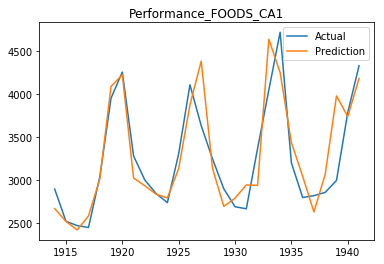

In [129]:
# report performance
rmse = sqrt(mean_squared_error(food_CA1_sales[-28:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
fig, ax = plt.subplots()
ax.plot(food_CA1.d_new[-28:], food_CA1.sales[-28:], label = 'Actual')
ax.plot(food_CA1.d_new[-28:], predictions, label = 'Prediction')
ax.set_title('Performance_FOODS_CA1')
ax.legend()